# Sharpe vs Return: A Study in DMAC Strategy Optimization

In [1]:
%pip install yfinance optuna matplotlib pandas numpy tabulate --quiet

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\medium\articles\sharpe_ratio_vs_return_optimizer\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Import Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import optuna
from optuna.samplers import TPESampler

plt.style.use('dark_background')

c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\medium\articles\sharpe_ratio_vs_return_optimizer\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Data

In [3]:
ticker = "NVDA"  # Ticker for NVIDIA

def get_data(ticker=ticker, start="2015-01-01", end="2024-12-31"):
    df = yf.download(ticker, start=start, end=end)
    df.columns = df.columns.get_level_values(0)
    df = df[['Close']]
    return df

data = get_data()
data.head()

C:\Users\Brian\AppData\Local\Temp\ipykernel_15816\103316922.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2015-01-02,0.483065
2015-01-05,0.474906
2015-01-06,0.460508
2015-01-07,0.459308
2015-01-08,0.476586


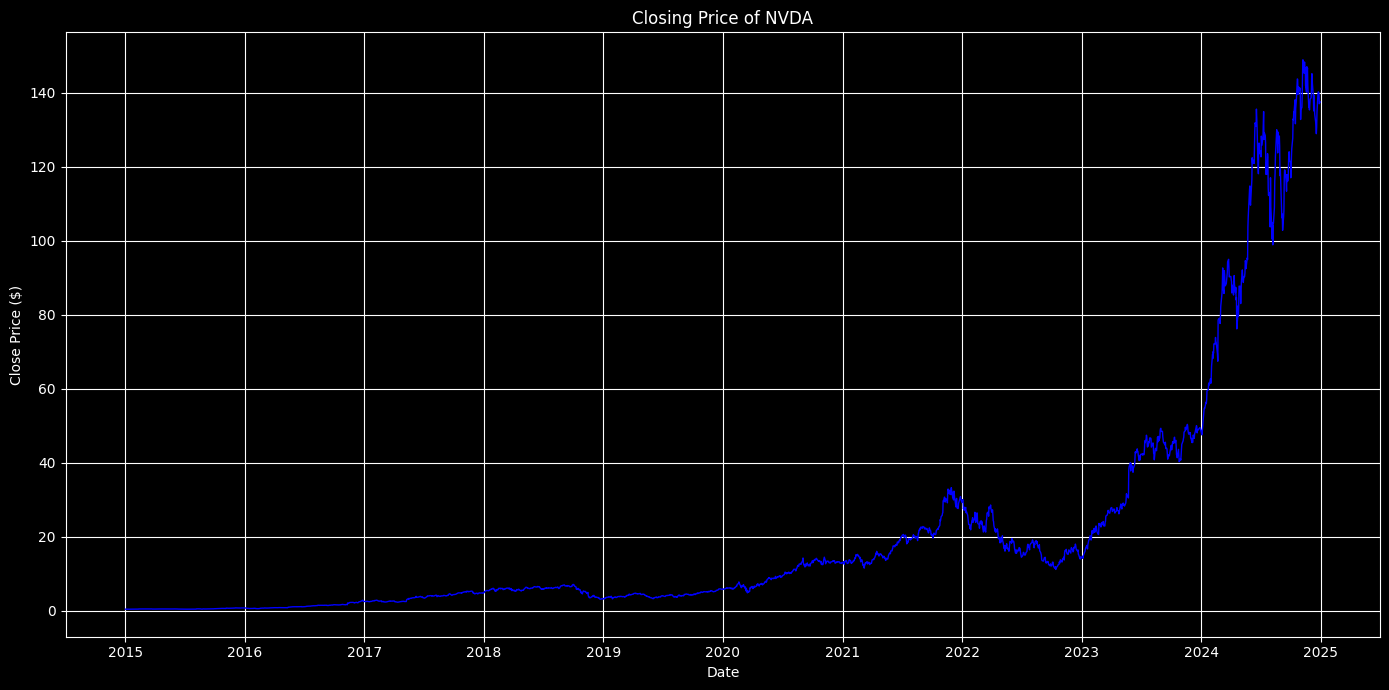

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], color='blue', linewidth=1)
plt.title(f'Closing Price of {ticker}')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True)
plt.tight_layout()
plt.savefig('closing_price_plot.png', dpi=300)
plt.show()

## Train/Test Split

In [5]:
# 80/20 train-test split
split_date = data.index[int(len(data) * 0.8)]
train_data = data[:split_date]
test_data = data[split_date:]
print(f"Train: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Test:  {test_data.index[0].date()} to {test_data.index[-1].date()}")

Train: 2015-01-02 to 2022-12-29
Test:  2022-12-29 to 2024-12-30


## Strategy

In [6]:
def apply_dmac(df, short_window, long_window):
    if short_window >= long_window:
        return pd.DataFrame()

    data = df.copy()
    data['short_ma'] = data['Close'].rolling(window=short_window).mean()
    data['long_ma'] = data['Close'].rolling(window=long_window).mean()

    # Long/flat signals: 1 = long, 0 = flat (cash)
    data['signal'] = 0
    data.loc[data['short_ma'] > data['long_ma'], 'signal'] = 1

    data['position'] = data['signal'].shift(1).fillna(0)

    # Buy and sell flags (optional for plotting)
    data['buy'] = (data['position'] == 1) & (data['position'].shift(1) == 0)
    data['sell'] = (data['position'] == 0) & (data['position'].shift(1) == 1)

    # Calculate returns
    data['returns'] = data['Close'].pct_change()
    data['strategy_returns'] = data['position'] * data['returns']

    # Zero returns before first trade
    first_pos_idx = data['position'].first_valid_index()
    if first_pos_idx is not None:
        data.loc[:first_pos_idx, 'strategy_returns'] = 0

    data.dropna(inplace=True)
    return data

## Sharpe Ratio

In [7]:
def calculate_sharpe(data, risk_free_rate=0.01):
    excess_returns = data['strategy_returns'] - risk_free_rate / 252
    sharpe = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    return sharpe

## Return

In [8]:
def calculate_total_return(data):
    cumulative = (1 + data['strategy_returns']).cumprod()
    return cumulative.iloc[-1] - 1  # Total return (not percentage)

## Sharpe Objective Function

In [9]:
def sharpe_objective(trial):
    short_window = trial.suggest_int("short_window", 5, 50)
    long_window = trial.suggest_int("long_window", short_window + 5, 200)

    df = apply_dmac(train_data, short_window, long_window)
    if df.empty or df['strategy_returns'].std() == 0:
        return -np.inf

    return calculate_sharpe(df)

## Return Objective Function

In [10]:
def return_objective(trial):
    short_window = trial.suggest_int("short_window", 5, 50)
    long_window = trial.suggest_int("long_window", short_window + 5, 200)

    df = apply_dmac(train_data, short_window, long_window)
    if df.empty:
        return -np.inf

    return calculate_total_return(df)

## Run Bayesian Optimization on Train Set

### Sharpe Optimization

In [11]:
# Sharpe Optimization
sampler1 = TPESampler(seed=42)
sharpe_study = optuna.create_study(direction="maximize", sampler=sampler1)
sharpe_study.optimize(sharpe_objective, n_trials=50)

print("Best Sharpe Ratio:", round(sharpe_study.best_value, 4))
print("Best Parameters:", sharpe_study.best_params)

[I 2025-07-13 22:38:14,235] A new study created in memory with name: no-name-ed4a4b07-11aa-4989-a111-203be96ae13d
[I 2025-07-13 22:38:14,248] Trial 0 finished with value: 1.2519082027631714 and parameters: {'short_window': 22, 'long_window': 192}. Best is trial 0 with value: 1.2519082027631714.
[I 2025-07-13 22:38:14,256] Trial 1 finished with value: 1.3458540130431513 and parameters: {'short_window': 38, 'long_window': 137}. Best is trial 1 with value: 1.3458540130431513.
[I 2025-07-13 22:38:14,265] Trial 2 finished with value: 1.0551644383237597 and parameters: {'short_window': 12, 'long_window': 45}. Best is trial 1 with value: 1.3458540130431513.
[I 2025-07-13 22:38:14,282] Trial 3 finished with value: 1.3257305255959115 and parameters: {'short_window': 7, 'long_window': 175}. Best is trial 1 with value: 1.3458540130431513.
[I 2025-07-13 22:38:14,322] Trial 4 finished with value: 1.2901399937698603 and parameters: {'short_window': 32, 'long_window': 153}. Best is trial 1 with value

Best Sharpe Ratio: 1.5201
Best Parameters: {'short_window': 50, 'long_window': 171}


### Sharpe Optimized Strategy Signals

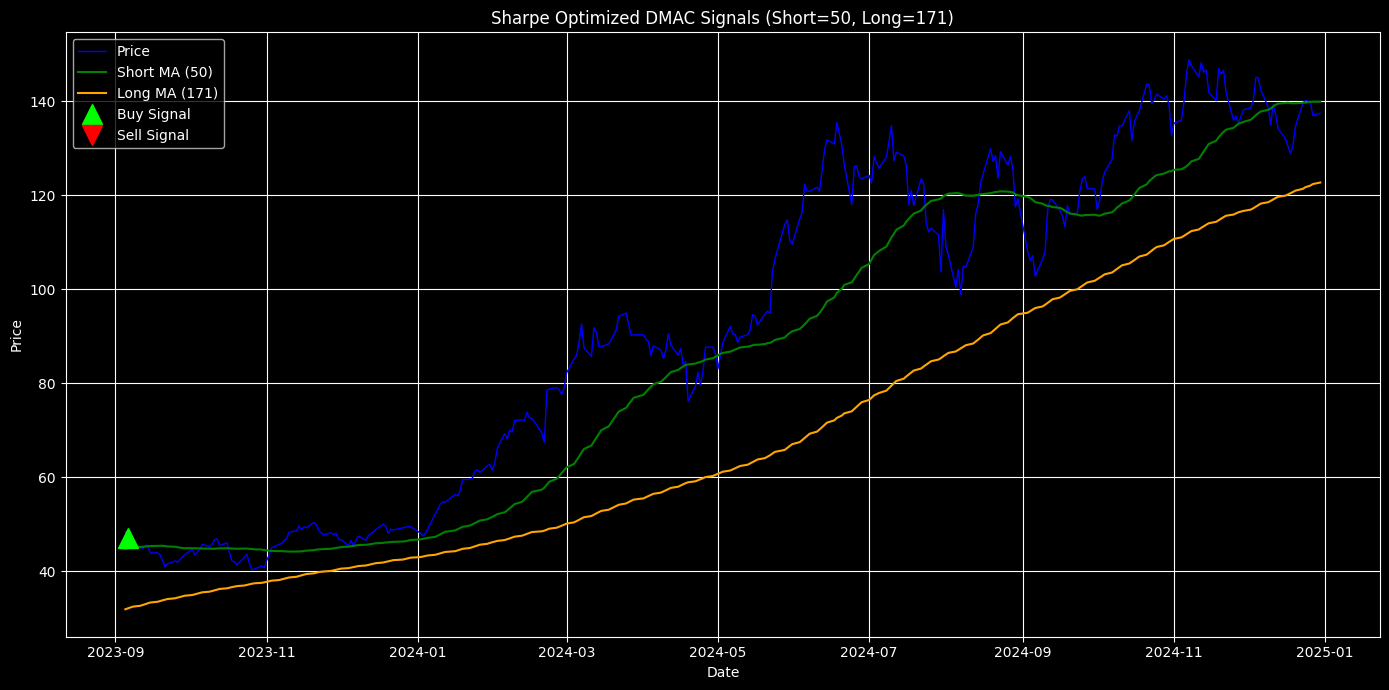

In [12]:
best_short_s = sharpe_study.best_params['short_window']
best_long_s = sharpe_study.best_params['long_window']
sharpe_df = apply_dmac(test_data, best_short_s, best_long_s)

plt.figure(figsize=(14, 7))
plt.plot(sharpe_df['Close'], label='Price', color='blue', linewidth=1)
plt.plot(sharpe_df['short_ma'], label=f'Short MA ({best_short_s})', color='green')
plt.plot(sharpe_df['long_ma'], label=f'Long MA ({best_long_s})', color='orange')

# Buy and Sell markers
plt.plot(sharpe_df[sharpe_df['buy']].index, sharpe_df[sharpe_df['buy']]['Close'],
         '^', markersize=14, color='lime', label='Buy Signal')
plt.plot(sharpe_df[sharpe_df['sell']].index, sharpe_df[sharpe_df['sell']]['Close'],
         'v', markersize=14, color='red', label='Sell Signal')

plt.title(f'Sharpe Optimized DMAC Signals (Short={best_short_s}, Long={best_long_s})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('sharpe_optimized_signals_plot.png', dpi=300)
plt.show()


### Return Optimization

In [13]:
sampler2 = TPESampler(seed=42)
return_study = optuna.create_study(direction="maximize", sampler=sampler2)
return_study.optimize(return_objective, n_trials=50)

print("Best Parameters:", return_study.best_params)

[I 2025-07-13 22:38:15,885] A new study created in memory with name: no-name-9c21772a-dd94-41e0-8fc2-dddbfaec1ec0
[I 2025-07-13 22:38:15,902] Trial 0 finished with value: 24.113728527008398 and parameters: {'short_window': 22, 'long_window': 192}. Best is trial 0 with value: 24.113728527008398.
[I 2025-07-13 22:38:15,916] Trial 1 finished with value: 33.6988289021931 and parameters: {'short_window': 38, 'long_window': 137}. Best is trial 1 with value: 33.6988289021931.
[I 2025-07-13 22:38:15,924] Trial 2 finished with value: 13.010338982778594 and parameters: {'short_window': 12, 'long_window': 45}. Best is trial 1 with value: 33.6988289021931.
[I 2025-07-13 22:38:15,932] Trial 3 finished with value: 29.613717413088647 and parameters: {'short_window': 7, 'long_window': 175}. Best is trial 1 with value: 33.6988289021931.
[I 2025-07-13 22:38:15,939] Trial 4 finished with value: 28.514367483651803 and parameters: {'short_window': 32, 'long_window': 153}. Best is trial 1 with value: 33.698

Best Parameters: {'short_window': 48, 'long_window': 172}


### Return Optimized Strategy Signals


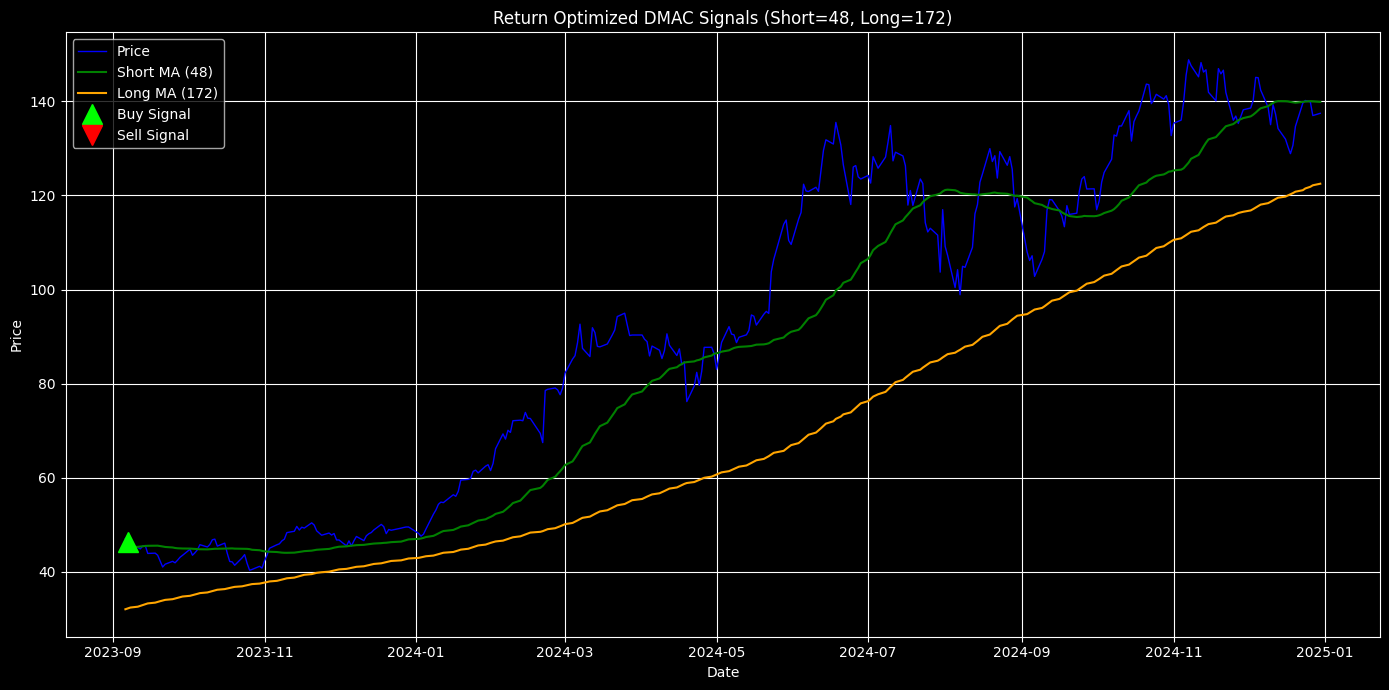

In [14]:
best_short_r = return_study.best_params['short_window']
best_long_r = return_study.best_params['long_window']
return_df = apply_dmac(test_data, best_short_r, best_long_r)

plt.figure(figsize=(14, 7))
plt.plot(return_df['Close'], label='Price', color='blue', linewidth=1)
plt.plot(return_df['short_ma'], label=f'Short MA ({best_short_r})', color='green')
plt.plot(return_df['long_ma'], label=f'Long MA ({best_long_r})', color='orange')

# Buy and Sell markers
plt.plot(return_df[return_df['buy']].index, return_df[return_df['buy']]['Close'],
         '^', markersize=14, color='lime', label='Buy Signal')
plt.plot(return_df[return_df['sell']].index, return_df[return_df['sell']]['Close'],
         'v', markersize=14, color='red', label='Sell Signal')

plt.title(f'Return Optimized DMAC Signals (Short={best_short_r}, Long={best_long_r})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('return_optimized_signals_plot.png', dpi=300)
plt.show()

## Evaluate Both Approaches on the test data

In [15]:
# Get best params for each
sharpe_best = sharpe_study.best_params
return_best = return_study.best_params

# Apply to test set
sharpe_df = apply_dmac(test_data, sharpe_best['short_window'], sharpe_best['long_window'])
return_df = apply_dmac(test_data, return_best['short_window'], return_best['long_window'])

# Cumulative returns
sharpe_cum = (1 + sharpe_df['strategy_returns']).cumprod()
return_cum = (1 + return_df['strategy_returns']).cumprod()
buy_hold_cum = (1 + test_data['Close'].pct_change()).cumprod()

## Plot Comparison

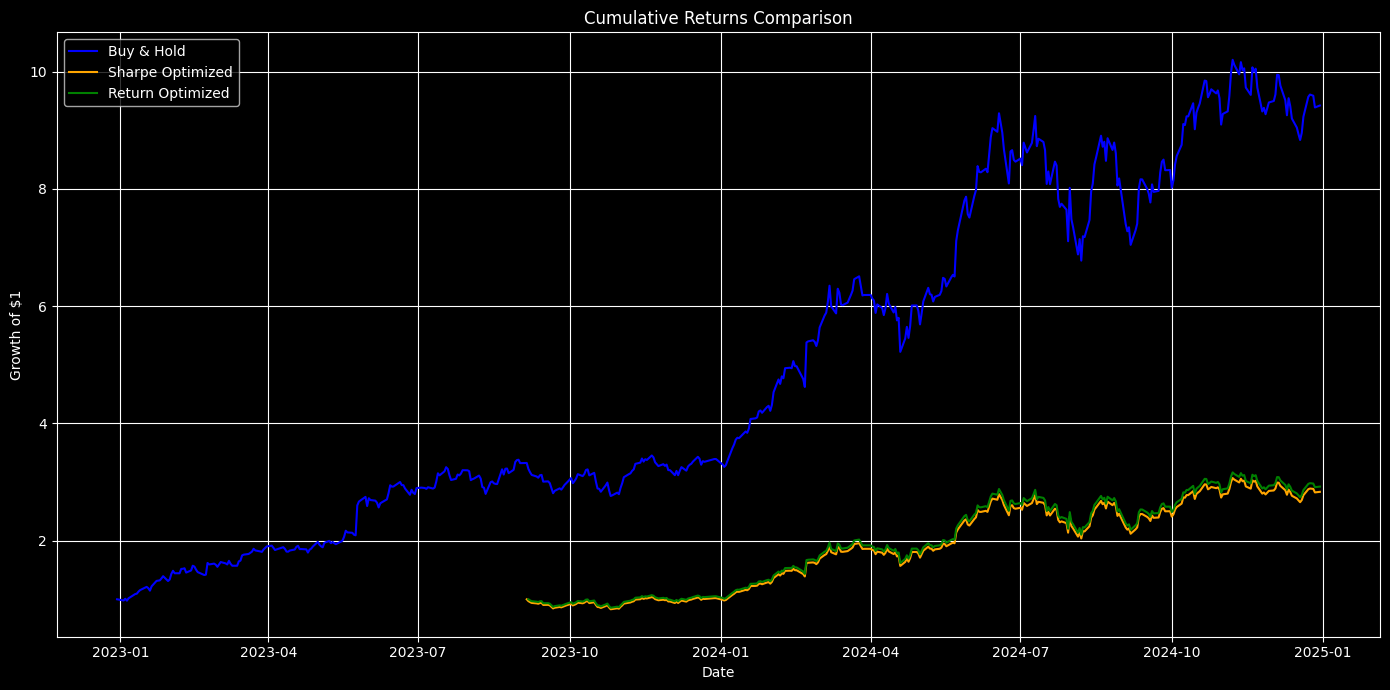

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, buy_hold_cum, label="Buy & Hold", color='blue')
plt.plot(sharpe_df.index, sharpe_cum, label=f"Sharpe Optimized", color='orange')
plt.plot(return_df.index, return_cum, label=f"Return Optimized", color='green')
plt.title("Cumulative Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("comparison_returns_plot.png", dpi=300)
plt.show()

## Final Metrics Summary

In [17]:
sharpe_final = sharpe_cum.iloc[-1]
return_final = return_cum.iloc[-1]
bh_final = buy_hold_cum.iloc[-1]

sharpe_return_pct = (sharpe_final - 1) * 100
return_return_pct = (return_final - 1) * 100
bh_return_pct = (bh_final - 1) * 100

table = [
    ["Strategy", "Final Value ($)", "Return (%)", "Sharpe", "Trades"],
    ["Sharpe Optimized", f"{sharpe_final:.2f}", f"{sharpe_return_pct:.2f}%", 
     f"{calculate_sharpe(sharpe_df):.2f}", int(sharpe_df['buy'].sum() + sharpe_df['sell'].sum())],
    ["Return Optimized", f"{return_final:.2f}", f"{return_return_pct:.2f}%", 
     f"{calculate_sharpe(return_df):.2f}", int(return_df['buy'].sum() + return_df['sell'].sum())],
    ["Buy & Hold", f"{bh_final:.2f}", f"{bh_return_pct:.2f}%", "—", "—"]
]

print(tabulate(table, headers="firstrow", tablefmt="rounded_grid"))

╭──────────────────┬───────────────────┬──────────────┬──────────┬──────────╮
│ Strategy         │   Final Value ($) │ Return (%)   │ Sharpe   │ Trades   │
├──────────────────┼───────────────────┼──────────────┼──────────┼──────────┤
│ Sharpe Optimized │              2.83 │ 183.33%      │ 1.85     │ 1        │
├──────────────────┼───────────────────┼──────────────┼──────────┼──────────┤
│ Return Optimized │              2.92 │ 192.26%      │ 1.90     │ 1        │
├──────────────────┼───────────────────┼──────────────┼──────────┼──────────┤
│ Buy & Hold       │              9.42 │ 842.20%      │ —        │ —        │
╰──────────────────┴───────────────────┴──────────────┴──────────┴──────────╯
